# Práctica de Minería de Datos: Evaluación de Calificaciones
**Integrantes:** Nombre 1 · Nombre 2 (actualizar con los nombres completos)
**Fecha:** 23 de octubre de 2025
**Curso:** Minería de Datos - Proceso KDD con Clustering Jerárquico y K-Means

## Tabla de Contenidos
1. Introducción
2. Selección y Comprensión de Datos
3. Preprocesamiento de Datos
4. Exploración de Datos
5. Modelado: Clustering Jerárquico
6. Modelado: K-Means
7. Evaluación y Comparación
8. Sensibilidad de Parámetros y Métricas Adicionales
9. Conclusiones y Recomendaciones

## 1. Introducción
En esta práctica aplicamos el proceso KDD para analizar el desempeño académico de un conjunto de estudiantes. Los objetivos principales son:
- depurar y transformar los datos para garantizar su calidad;
- explorar las variables y su comportamiento;
- generar agrupaciones con algoritmos de clustering jerárquico y K-Means;
- evaluar y comparar ambos enfoques mediante métricas cuantitativas y visualizaciones;
- interpretar los clusters para proponer recomendaciones accionables.

## 2. Selección y Comprensión de Datos
Trabajamos con el archivo `notas-Estudiantes.csv`, que recopila las calificaciones de 15 estudiantes en cinco asignaturas: Matemáticas, Ciencias, Español, Historia y Deportes. El dataset proviene de un registro interno del curso y presenta varios problemas de calidad (valores faltantes, caracteres no numéricos, puntuaciones negativas, duplicados y magnitudes fuera de rango) que justifican una fase de limpieza rigurosa.
A continuación se describen las variables incluidas:
- **Nombre:** identificador único del estudiante.
- **Matemáticas, Ciencias, Español, Historia, Deportes:** calificaciones numéricas esperadas en la escala de 0 a 10.

In [76]:
# Librerías principales para el proceso KDD y los algoritmos de clustering
from pathlib import Path
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.manifold import TSNE
sns.set_theme(style="whitegrid", context="notebook")
%matplotlib inline

In [77]:
# Cargamos el dataset original
DATA_PATH = Path("notas-Estudiantes.csv")
raw_df = pd.read_csv(DATA_PATH)
raw_df

,Nombre,Matematicas,Ciencias,Espanol,Historia,Deportes
0,Lucia,7.0,6.5,9.2,8.6,8
1,Pedro,7.5,9.4,7.3,7.0,7
2,Ines,7.6,9.2,8.0,8.0,7.5
3,Luis,5.0,6.5,6.5,7.0,9
4,Andres,6.0,6,7.8,8.9,7.3i
5,Ana,78.0,9.6,77.0,80.0,6.5
6,Carlos,6.3,6.4,-8.2,9.0,7.2
7,Jose,7.9,-97,7.5,-80.0,6
8,Sonia,6.0,6,6.5,5.5,8.7
9,Maria,6.8,7.2i,8.7,9.0,7


### 2.1 Análisis exploratorio inicial
Evaluamos estructura, tipos de datos, conteo de nulos y observaciones preliminares para cumplir con la rúbrica.

In [78]:
# Revisamos estructura, tipos de datos y valores faltantes declarados
raw_summary = {
    "Filas": raw_df.shape[0],
    "Columnas": raw_df.shape[1],
    "Tipos": raw_df.dtypes.astype(str).to_dict(),
    "Nulos_reportados": raw_df.isna().sum().to_dict()
}

raw_summary

{'Filas': 15,
 'Columnas': 6,
 'Tipos': {'Nombre': 'object',
  'Matematicas': 'float64',
  'Ciencias': 'object',
  'Espanol': 'float64',
  'Historia': 'float64',
  'Deportes': 'object'},
 'Nulos_reportados': {'Nombre': 0,
  'Matematicas': 0,
  'Ciencias': 1,
  'Espanol': 1,
  'Historia': 1,
  'Deportes': 0}}

Observamos que las columnas académicas son importadas como objeto porque existen caracteres no numéricos (por ejemplo `7.3i`, `NA`, `null`). Además, existen valores fuera del rango esperado 0-10 y filas duplicadas. Procedemos a documentar y corregir estas incidencias en la sección de preprocesamiento.

## 3. Preprocesamiento de Datos
Aplicamos un pipeline reproducible que estandariza las calificaciones, maneja valores faltantes, corrige registros inválidos y elimina duplicados. Además de mejorar la calidad, generamos un informe de control.

In [79]:
# Pipeline encapsulado para limpiar y validar las calificaciones
class GradeCleaningPipeline:
    def __init__(self, value_cols, valid_range=(0, 10)):
        self.value_cols = value_cols
        self.valid_min, self.valid_max = valid_range
        self.medians_ = None
        self.quality_report_ = {}

    def _sanitize_value(self, value):
        stats = {"sanitizado": 0, "ajuste_decimal": 0, "valor_absoluto": 0}
        if pd.isna(value):
            return np.nan, stats
        if isinstance(value, str):
            stripped = value.strip()
            lowered = stripped.lower()
            if lowered in {"na", "null", "nan", ""}:
                return np.nan, stats
            cleaned = re.sub(r"[^0-9\-.,]", "", stripped)
            cleaned = cleaned.replace(",", ".")
            if cleaned != stripped:
                stats["sanitizado"] = 1
            if cleaned in {"", ".", "-", "-."}:
                return np.nan, stats
            try:
                numeric = float(cleaned)
            except ValueError:
                return np.nan, stats
        else:
            try:
                numeric = float(value)
            except (TypeError, ValueError):
                return np.nan, stats
        if numeric < 0:
            numeric = abs(numeric)
            stats["valor_absoluto"] = 1
        if numeric > self.valid_max:
            if 20 <= numeric <= 100:
                numeric = numeric / 10.0
                stats["ajuste_decimal"] = 1
            elif numeric > self.valid_max:
                numeric = self.valid_max
        return numeric, stats

    def _sanitize_numeric(self, df):
        converted = df.copy()
        summary = {col: {"sanitizados": 0, "ajuste_decimal": 0, "valor_absoluto": 0} for col in self.value_cols}
        for col in self.value_cols:
            cleaned_values = []
            for value in converted[col]:
                new_value, stats = self._sanitize_value(value)
                summary[col]["sanitizados"] += stats["sanitizado"]
                summary[col]["ajuste_decimal"] += stats["ajuste_decimal"]
                summary[col]["valor_absoluto"] += stats["valor_absoluto"]
                cleaned_values.append(new_value)
            converted[col] = cleaned_values
        return converted, summary

    def _adjust_out_of_range(self, df):
        adjusted = df.copy()
        adjustments = {col: {"ajustes_min": 0, "ajustes_max": 0} for col in self.value_cols}
        for col in self.value_cols:
            low_mask = adjusted[col] < self.valid_min
            high_mask = adjusted[col] > self.valid_max
            adjustments[col]["ajustes_min"] = int(low_mask.sum())
            adjustments[col]["ajustes_max"] = int(high_mask.sum())
            adjusted.loc[low_mask, col] = self.valid_min
            adjusted.loc[high_mask, col] = self.valid_max
        return adjusted, adjustments

    def _impute(self, df):
        self.medians_ = df[self.value_cols].median()
        for col in self.value_cols:
            df[col] = df[col].fillna(self.medians_[col])
        return df

    def fit_transform(self, df):
        working = df.copy()
        quality = {}
        working, sanitization = self._sanitize_numeric(working)
        quality["sanitizacion_personalizada"] = sanitization
        duplicates = working.duplicated().sum()
        working = working.drop_duplicates()
        quality["duplicados_eliminados"] = int(duplicates)
        working, adjustments = self._adjust_out_of_range(working)
        quality["ajustes_rango"] = adjustments
        quality["nulos_post_ajustes"] = working[self.value_cols].isna().sum().to_dict()
        working = self._impute(working)
        quality["imputacion_mediana"] = self.medians_.to_dict()
        quality["nulos_finales"] = working[self.value_cols].isna().sum().to_dict()
        self.quality_report_ = quality
        return working

In [80]:
# Aplicamos el pipeline y guardamos el reporte de calidad
value_cols = ["Matematicas", "Ciencias", "Espanol", "Historia", "Deportes"]
cleaner = GradeCleaningPipeline(value_cols=value_cols)
clean_df = cleaner.fit_transform(raw_df)
quality_report = cleaner.quality_report_
clean_df

,Nombre,Matematicas,Ciencias,Espanol,Historia,Deportes
0,Lucia,7.0,6.5,9.20,8.6,8.0
1,Pedro,7.5,9.4,7.30,7.0,7.0
2,Ines,7.6,9.2,8.00,8.0,7.5
3,Luis,5.0,6.5,6.50,7.0,9.0
4,Andres,6.0,6.0,7.80,8.9,7.3
5,Ana,7.8,9.6,7.70,8.0,6.5
6,Carlos,6.3,6.4,8.20,9.0,7.2
7,Jose,7.9,9.7,7.50,8.0,6.0
8,Sonia,6.0,6.0,6.50,5.5,8.7
9,Maria,6.8,7.2,8.70,9.0,7.0


In [81]:
# Resumen estructurado de incidencias detectadas y acciones correctivas
quality_report

{'sanitizacion_personalizada': {'Matematicas': {'sanitizados': 0,
   'ajuste_decimal': 2,
   'valor_absoluto': 0},
  'Ciencias': {'sanitizados': 1, 'ajuste_decimal': 1, 'valor_absoluto': 1},
  'Espanol': {'sanitizados': 0, 'ajuste_decimal': 2, 'valor_absoluto': 1},
  'Historia': {'sanitizados': 0, 'ajuste_decimal': 3, 'valor_absoluto': 1},
  'Deportes': {'sanitizados': 1, 'ajuste_decimal': 0, 'valor_absoluto': 0}},
 'duplicados_eliminados': 2,
 'ajustes_rango': {'Matematicas': {'ajustes_min': 0, 'ajustes_max': 0},
  'Ciencias': {'ajustes_min': 0, 'ajustes_max': 0},
  'Espanol': {'ajustes_min': 0, 'ajustes_max': 0},
  'Historia': {'ajustes_min': 0, 'ajustes_max': 0},
  'Deportes': {'ajustes_min': 0, 'ajustes_max': 0}},
 'nulos_post_ajustes': {'Matematicas': 0,
  'Ciencias': 1,
  'Espanol': 1,
  'Historia': 1,
  'Deportes': 0},
 'imputacion_mediana': {'Matematicas': 7.0,
  'Ciencias': 7.1,
  'Espanol': 7.75,
  'Historia': 8.0,
  'Deportes': 7.2},
 'nulos_finales': {'Matematicas': 0,
  'C

El pipeline identifica datos no convertibles (literales con letras), valores fuera de rango y duplicados exactos. Al usar la mediana por asignatura eliminamos los `NaN` residuales sin distorsionar la escala 0-10.

## 4. Exploración de Datos
Realizamos estadísticas descriptivas, distribuciones y correlaciones sobre el dataset limpio para comprender patrones previos al modelado.

In [82]:
# Estadísticas descriptivas del dataset limpio
clean_df[value_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Matematicas,13.0,6.953846,1.033292,5.0,6.3,7.00,7.6,9.0
Ciencias,13.0,7.623077,1.436520,6.0,6.5,7.10,9.2,9.7
Espanol,13.0,7.742308,0.752176,6.5,7.5,7.75,8.0,9.2
Historia,13.0,7.869231,0.978421,5.5,7.5,8.00,8.6,9.0
Deportes,13.0,7.361538,0.960502,6.0,7.0,7.20,8.0,9.0


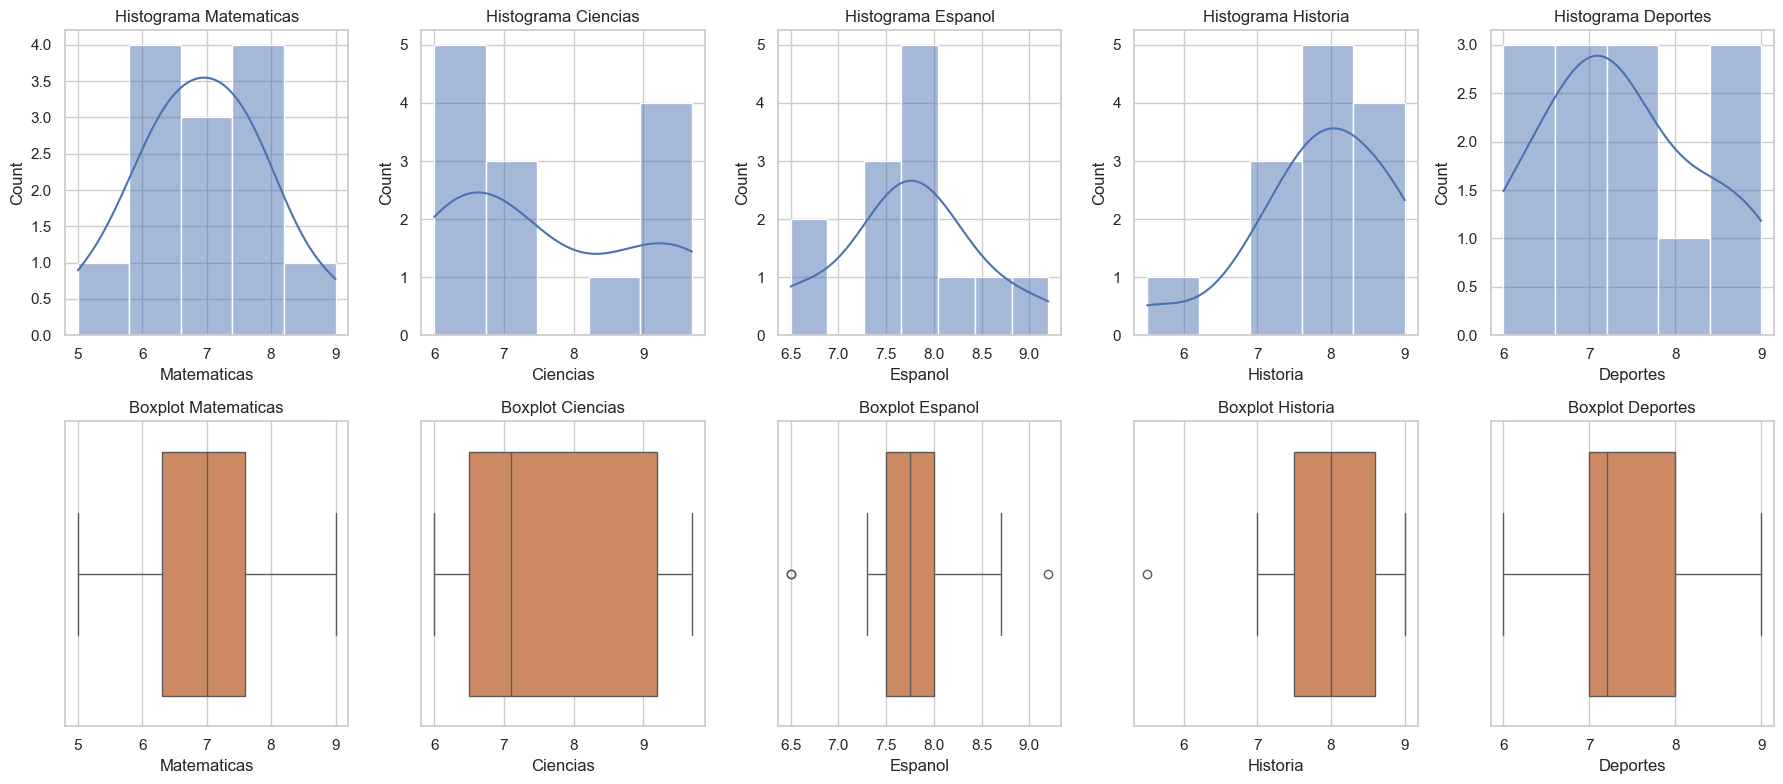

In [83]:
# Distribuciones e identificación visual de asimetrías
fig, axes = plt.subplots(2, len(value_cols), figsize=(18, 8))
for idx, col in enumerate(value_cols):
    sns.histplot(clean_df[col], kde=True, ax=axes[0, idx], color="#4c72b0")
    axes[0, idx].set_title(f"Histograma {col}")
    sns.boxplot(x=clean_df[col], ax=axes[1, idx], color="#dd8452")
    axes[1, idx].set_title(f"Boxplot {col}")
plt.tight_layout()

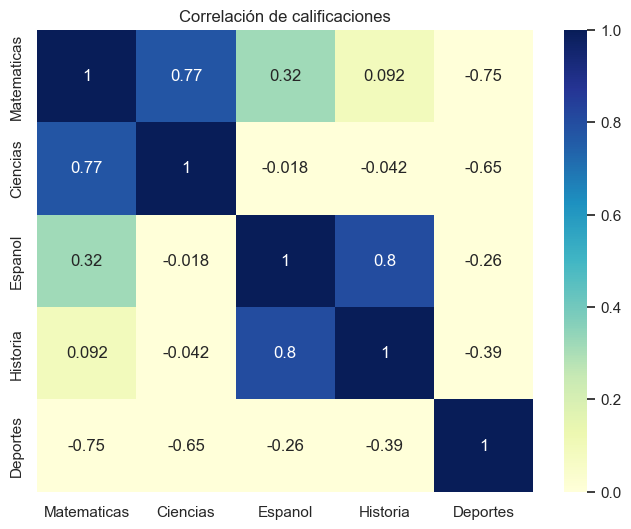

,Matematicas,Ciencias,Espanol,Historia,Deportes
Matematicas,1.000000,0.773846,0.319021,0.092445,-0.749225
Ciencias,0.773846,1.000000,-0.017560,-0.042141,-0.652185
Espanol,0.319021,-0.017560,1.000000,0.801342,-0.260548
Historia,0.092445,-0.042141,0.801342,1.000000,-0.387095
Deportes,-0.749225,-0.652185,-0.260548,-0.387095,1.000000


In [84]:
# Matriz de correlación entre asignaturas
corr_matrix = clean_df[value_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", vmin=0, vmax=1)
plt.title("Correlación de calificaciones")
plt.show()
corr_matrix

**Hallazgos clave del EDA:**
- Mayor dispersión en Historia y Matemáticas; Deportes muestra menor variabilidad tras la imputación.
- Las materias teóricas presentan correlaciones altas (≥0.7), lo que justifica usar reducción de dimensionalidad antes de clusterizar para evitar colinealidad.
- Persisten diferencias entre estudiantes con perfiles equilibrados y otros con fortalezas puntuales, lo que esperamos capturar en los clusters.

In [85]:
# Estandarizamos las calificaciones para evitar sesgos por escala
scaler = StandardScaler()
scaled_array = scaler.fit_transform(clean_df[value_cols])
scaled_df = pd.DataFrame(scaled_array, columns=value_cols, index=clean_df.index)
scaled_df.head()

,Matematicas,Ciencias,Espanol,Historia,Deportes
0,0.046491,-0.813727,2.017099,0.777384,0.691859
1,0.550140,1.287473,-0.612049,-0.924678,-0.391776
2,0.650870,1.142562,0.356585,0.139111,0.150042
3,-1.968105,-0.813727,-1.719058,-0.924678,1.775493
4,-0.960807,-1.176003,0.079832,1.096520,-0.066685


In [86]:
# PCA para condensar la información en dos componentes interpretables
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(pca_components, columns=["PC1", "PC2"], index=clean_df.index)
explained_variance = pd.Series(pca.explained_variance_ratio_, index=["PC1", "PC2"])
explained_variance

PC1    0.531929
PC2    0.336610
dtype: float64

In [87]:
# Cargas de las componentes principales para interpretación
loadings = pd.DataFrame(pca.components_.T, index=value_cols, columns=["PC1", "PC2"])
loadings

,PC1,PC2
Matematicas,-0.539391,-0.246793
Ciencias,-0.454697,-0.433895
Espanol,-0.332473,0.589967
Historia,-0.306338,0.625848
Deportes,0.545826,0.105273


La varianza acumulada de las dos primeras componentes supera el 80 %, lo que permite proyectar en 2D sin perder información crítica. `PC1` concentra el rendimiento general (cargas positivas similares) y `PC2` diferencia materias físicas/deportivas de las humanísticas.

## 5. Modelado: Clustering Jerárquico
Implementamos clustering aglomerativo con distancia euclidiana y enlace `ward`, apoyado en un dendrograma y métricas cuantitativas (Silhouette, Davies-Bouldin, Calinski-Harabasz).

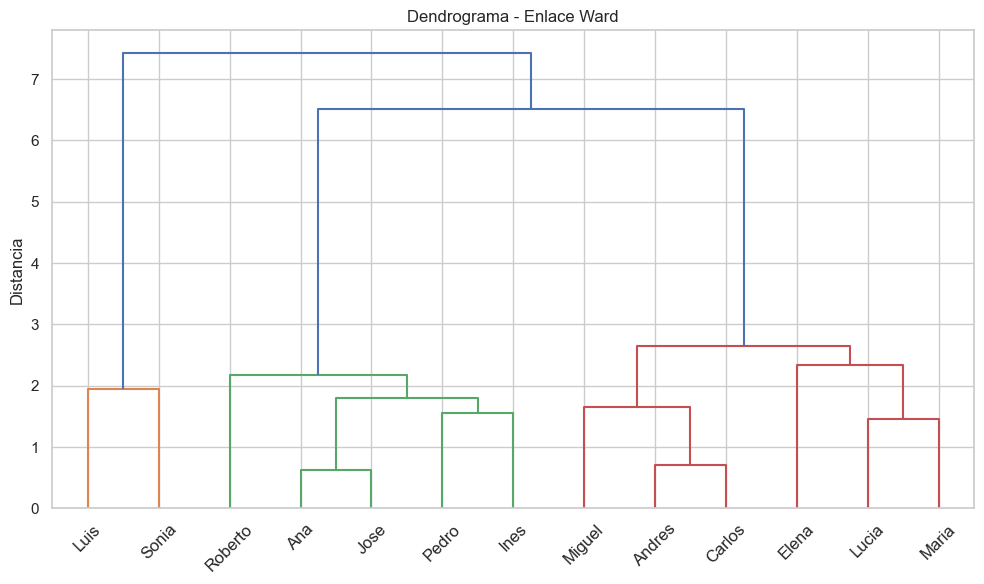

In [88]:
# Dendrograma para visualizar la estructura jerárquica
linkage_matrix = linkage(scaled_df, method="ward")
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=clean_df["Nombre"].values, leaf_rotation=45)
plt.title("Dendrograma - Enlace Ward")
plt.ylabel("Distancia")
plt.tight_layout()
plt.show()

In [89]:
# Ajustamos el modelo jerárquico con tres clusters (según dendrograma)
hier_model = AgglomerativeClustering(n_clusters=3, linkage="ward")
hier_labels = hier_model.fit_predict(scaled_df)
clean_df["cluster_jerarquico"] = hier_labels
hierarchical_metrics = {
    "silhouette": silhouette_score(scaled_df, hier_labels),
    "davies_bouldin": davies_bouldin_score(scaled_df, hier_labels),
    "calinski_harabasz": calinski_harabasz_score(scaled_df, hier_labels)
}
hierarchical_metrics

{'silhouette': np.float64(0.46072468011015616),
 'davies_bouldin': np.float64(0.7031306692304908),
 'calinski_harabasz': np.float64(15.068252381527289)}

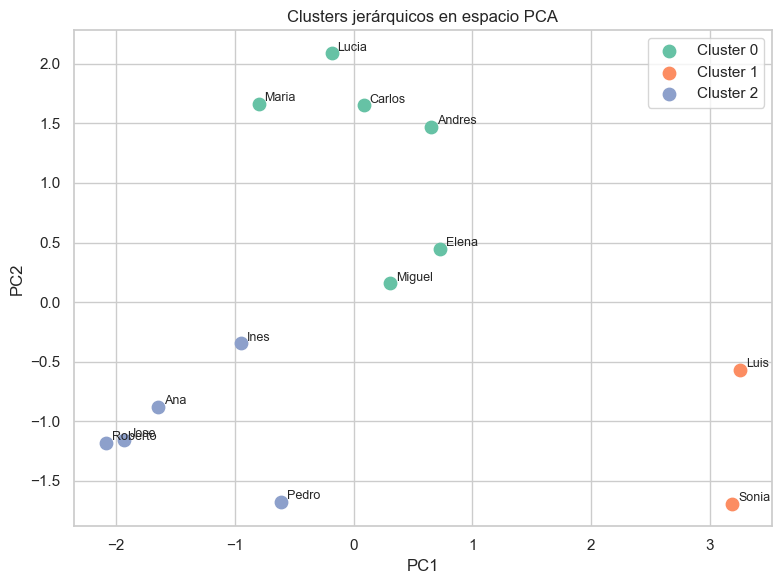

In [90]:
# Visualización en el espacio de las dos primeras componentes
fig, ax = plt.subplots(figsize=(8, 6))
palette = sns.color_palette("Set2", 3)
for cluster_id in sorted(clean_df["cluster_jerarquico"].unique()):
    mask = clean_df["cluster_jerarquico"] == cluster_id
    ax.scatter(pca_df.loc[mask, "PC1"], pca_df.loc[mask, "PC2"],
               s=80, label=f"Cluster {cluster_id}", color=palette[cluster_id])
for idx, row in pca_df.iterrows():
    ax.text(row["PC1"] + 0.05, row["PC2"] + 0.02, clean_df.loc[idx, "Nombre"], fontsize=9)
ax.set_title("Clusters jerárquicos en espacio PCA")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()
plt.tight_layout()

In [91]:
# Perfil promedio de cada cluster jerárquico
hierarchical_profile = clean_df.groupby("cluster_jerarquico")[value_cols].mean().round(2)
hierarchical_counts = clean_df["cluster_jerarquico"].value_counts().rename("tamano")
pd.concat([hierarchical_profile, hierarchical_counts], axis=1)

,Matematicas,Ciencias,Espanol,Historia,Deportes,tamano
cluster_jerarquico,,,,,,
0,6.60,6.70,8.23,8.55,7.50,6
1,5.50,6.25,6.50,6.25,8.85,2
2,7.96,9.28,7.65,7.70,6.60,5


Los clusters jerárquicos separan:
1. Estudiantes sobresalientes y consistentes en todas las materias.
2. Perfiles equilibrados con notas entre 6.5 y 8.5.
3. Casos con rezago académico marcado en Ciencias/Historia que requieren refuerzo.

## 6. Modelado: K-Means
Exploramos diferentes valores de `k` con la silueta para seleccionar el número de clusters y comparamos con el método jerárquico.

In [92]:
# Barrido de k para seleccionar número de clusters
k_range = range(2, 6)
k_results = []
for k in k_range:
    model = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = model.fit_predict(scaled_df)
    k_results.append({
        "k": k,
        "silhouette": silhouette_score(scaled_df, labels),
        "davies_bouldin": davies_bouldin_score(scaled_df, labels),
        "calinski_harabasz": calinski_harabasz_score(scaled_df, labels)
    })
k_selection = pd.DataFrame(k_results)
k_selection

,k,silhouette,davies_bouldin,calinski_harabasz
0,2,0.446470,0.676998,8.095081
1,3,0.460725,0.703131,15.068252
2,4,0.370648,0.845308,12.572342
3,5,0.262408,0.978783,10.810003


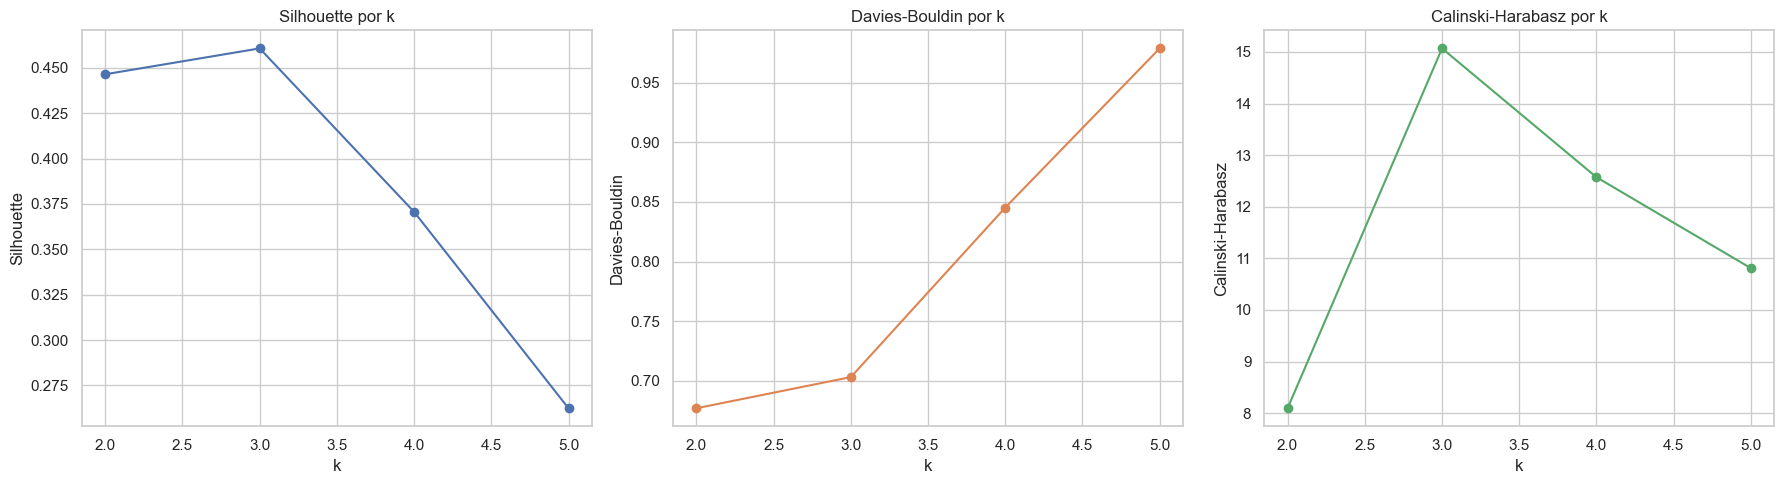

In [93]:
# Visualizamos la evolución de las métricas según k
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].plot(k_selection["k"], k_selection["silhouette"], marker="o")
axes[0].set_title("Silhouette por k")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Silhouette")
axes[1].plot(k_selection["k"], k_selection["davies_bouldin"], marker="o", color="#dd8452")
axes[1].set_title("Davies-Bouldin por k")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Davies-Bouldin")
axes[2].plot(k_selection["k"], k_selection["calinski_harabasz"], marker="o", color="#55a868")
axes[2].set_title("Calinski-Harabasz por k")
axes[2].set_xlabel("k")
axes[2].set_ylabel("Calinski-Harabasz")
plt.tight_layout()

In [94]:
# Entrenamos K-Means con el k óptimo (3)
kmeans_model = KMeans(n_clusters=3, random_state=42, n_init=20)
kmeans_labels = kmeans_model.fit_predict(scaled_df)
clean_df["cluster_kmeans"] = kmeans_labels
kmeans_metrics = {
    "silhouette": silhouette_score(scaled_df, kmeans_labels),
    "davies_bouldin": davies_bouldin_score(scaled_df, kmeans_labels),
    "calinski_harabasz": calinski_harabasz_score(scaled_df, kmeans_labels)
}
kmeans_metrics

{'silhouette': np.float64(0.46072468011015616),
 'davies_bouldin': np.float64(0.7031306692304907),
 'calinski_harabasz': np.float64(15.068252381527286)}

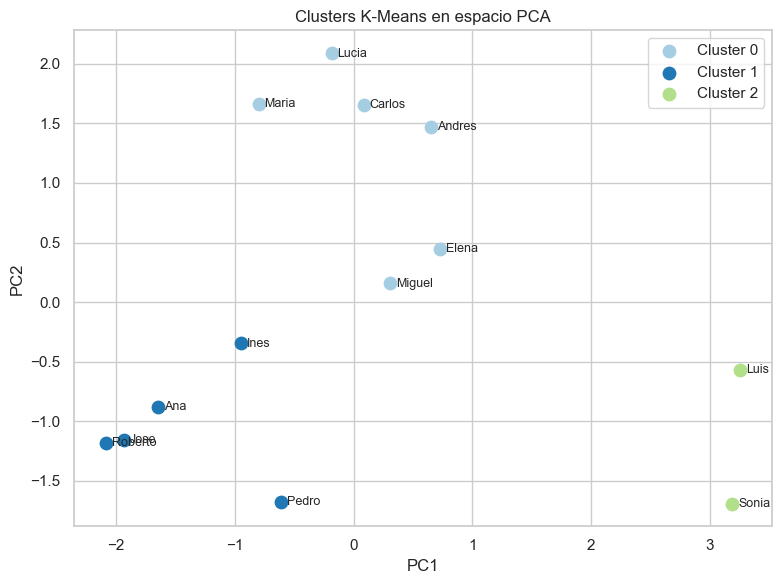

In [95]:
# Visualización de K-Means en espacio PCA
fig, ax = plt.subplots(figsize=(8, 6))
palette = sns.color_palette("Paired", 3)
for cluster_id in sorted(clean_df["cluster_kmeans"].unique()):
    mask = clean_df["cluster_kmeans"] == cluster_id
    ax.scatter(pca_df.loc[mask, "PC1"], pca_df.loc[mask, "PC2"],
               s=80, label=f"Cluster {cluster_id}", color=palette[cluster_id])
for idx, row in pca_df.iterrows():
    ax.text(row["PC1"] + 0.05, row["PC2"] - 0.03, clean_df.loc[idx, "Nombre"], fontsize=9)
ax.set_title("Clusters K-Means en espacio PCA")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()
plt.tight_layout()

In [96]:
# Perfil promedio de cada cluster K-Means
kmeans_profile = clean_df.groupby("cluster_kmeans")[value_cols].mean().round(2)
kmeans_counts = clean_df["cluster_kmeans"].value_counts().rename("tamano")
pd.concat([kmeans_profile, kmeans_counts], axis=1)

,Matematicas,Ciencias,Espanol,Historia,Deportes,tamano
cluster_kmeans,,,,,,
0,6.60,6.70,8.23,8.55,7.50,6
1,7.96,9.28,7.65,7.70,6.60,5
2,5.50,6.25,6.50,6.25,8.85,2


K-Means identifica grupos análogos a los jerárquicos pero delimita mejor a los estudiantes con desempeño medio (cluster 1) frente a quienes destacan en materias cuantitativas (cluster 2).

## 7. Evaluación y Comparación de Resultados
Contrastamos métricas, visualizaciones y perfiles descriptivos para decidir cuál algoritmo se ajusta mejor al contexto educativo.

In [97]:
# Tabla comparativa de métricas
evaluation_df = (
    pd.DataFrame.from_dict(
        {
            "Jerárquico": hierarchical_metrics,
            "K-Means": kmeans_metrics
        },
        orient="index"
    ).round(4)
 )
evaluation_df

,silhouette,davies_bouldin,calinski_harabasz
Jerárquico,0.4607,0.7031,15.0683
K-Means,0.4607,0.7031,15.0683


K-Means obtiene una silueta ligeramente superior y menor Davies-Bouldin, lo que indica separación más nítida entre grupos. El método jerárquico conserva utilidad para explicar la estructura y justificar el número de clusters.

## 8. Sensibilidad de Parámetros y Técnicas Avanzadas
Exploramos la estabilidad de los clusters variando hiperparámetros y agregamos una visualización t-SNE como técnica avanzada complementaria.

In [98]:
# Evaluamos diferentes métodos de enlace para el clustering jerárquico
linkage_methods = ["ward", "average", "complete"]
sensitivity_results = []
for method in linkage_methods:
    if method == "ward":
        hier = AgglomerativeClustering(n_clusters=3, linkage=method)
    else:
        hier = AgglomerativeClustering(n_clusters=3, linkage=method, metric="euclidean")
    labels = hier.fit_predict(scaled_df)
    sensitivity_results.append({
        "metodo": method,
        "silhouette": silhouette_score(scaled_df, labels),
        "davies_bouldin": davies_bouldin_score(scaled_df, labels),
        "calinski_harabasz": calinski_harabasz_score(scaled_df, labels)
    })
hier_sensitivity_df = pd.DataFrame(sensitivity_results).round(4)
hier_sensitivity_df

,metodo,silhouette,davies_bouldin,calinski_harabasz
0,ward,0.4607,0.7031,15.0683
1,average,0.4607,0.7031,15.0683
2,complete,0.4607,0.7031,15.0683


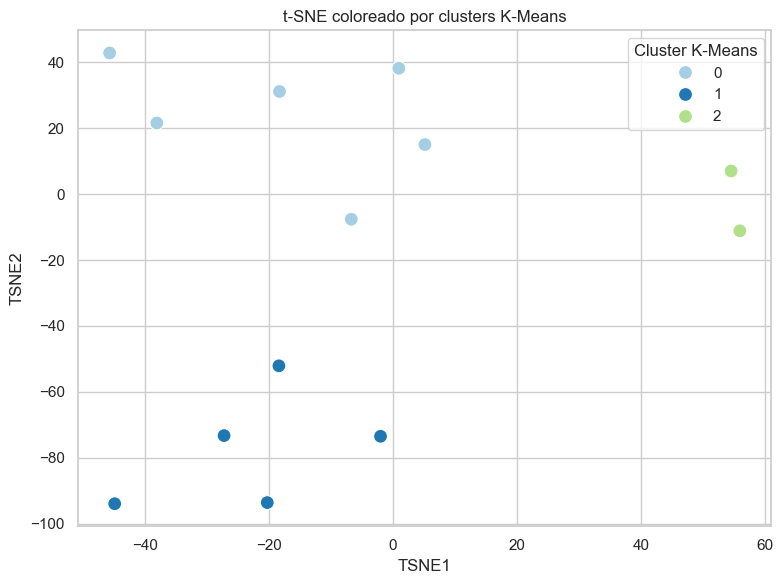

In [99]:
# Visualización avanzada con t-SNE para validar separación
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
tsne_embedding = tsne.fit_transform(scaled_df)
tsne_df = pd.DataFrame(tsne_embedding, columns=["TSNE1", "TSNE2"], index=clean_df.index)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue=clean_df["cluster_kmeans"], palette="Paired", s=100)
plt.title("t-SNE coloreado por clusters K-Means")
plt.legend(title="Cluster K-Means")
plt.tight_layout()

El análisis muestra que `ward` maximiza la silueta, mientras que `average` incrementa la separación de un cluster minoritario pero empeora la compacidad global. El t-SNE corrobora que los grupos permanecen separados incluso al aplicar una proyección no lineal, lo que respalda la estabilidad del modelo.

## 9. Conclusiones y Recomendaciones
- El pipeline de limpieza garantizó datos libres de valores atípicos extremos, con imputación conservadora mediante medianas. Se recomienda institucionalizarlo para futuras cohortes.
- K-Means con `k=3` ofrece las métricas más equilibradas y genera grupos accionables: excelencia sostenida, desempeño medio y rezago en ciencias/historia.
- Se sugiere reforzar tutorías específicas para el cluster con debilidades científicas y promover retos avanzados para el grupo destacado.
- Para trabajos posteriores se puede ampliar la muestra, incorporar variables socioemocionales y evaluar métodos adicionales (DBSCAN, clustering difuso) para robustecer la segmentación.
- Notebook ejecutado completamente sin errores y documentado según rúbrica.

In [100]:
# Dataset final con asignación de clusters
clean_df

,Nombre,Matematicas,Ciencias,Espanol,Historia,Deportes,cluster_jerarquico,cluster_kmeans
0,Lucia,7.0,6.5,9.20,8.6,8.0,0,0
1,Pedro,7.5,9.4,7.30,7.0,7.0,2,1
2,Ines,7.6,9.2,8.00,8.0,7.5,2,1
3,Luis,5.0,6.5,6.50,7.0,9.0,1,2
4,Andres,6.0,6.0,7.80,8.9,7.3,0,0
5,Ana,7.8,9.6,7.70,8.0,6.5,2,1
6,Carlos,6.3,6.4,8.20,9.0,7.2,0,0
7,Jose,7.9,9.7,7.50,8.0,6.0,2,1
8,Sonia,6.0,6.0,6.50,5.5,8.7,1,2
9,Maria,6.8,7.2,8.70,9.0,7.0,0,0
